Shape: (148670, 34)
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           

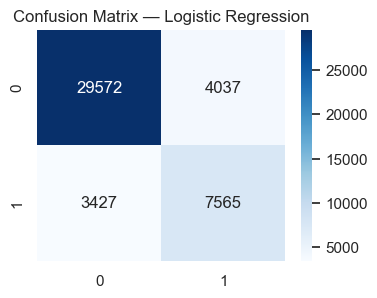


Training Model: Naive Bayes


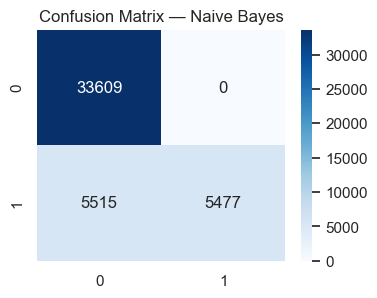


Training Model: SVM


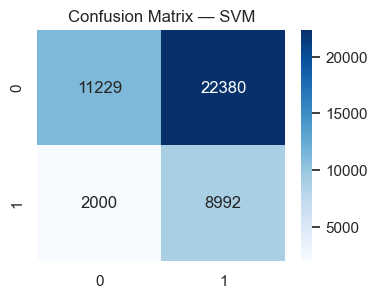


Training Model: Decision Tree


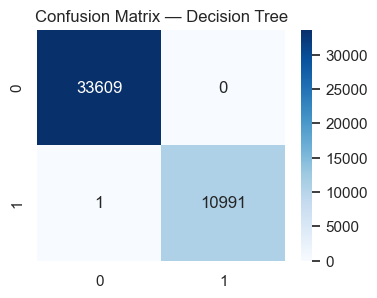


Training Model: Random Forest


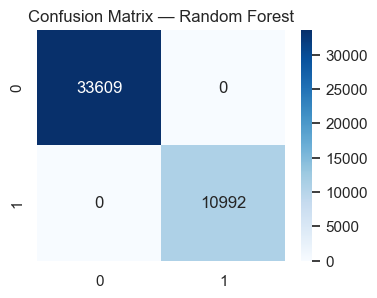


Training Model: XGBoost


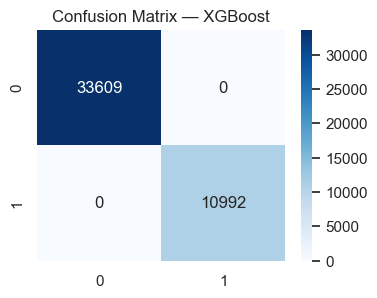


Training Model: KNN


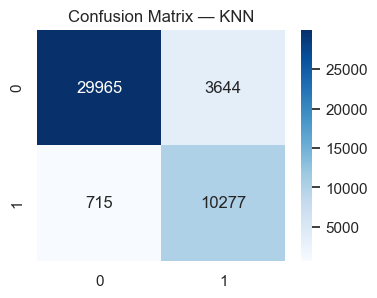


===== FINAL RESULTS =====

                 Model  Train Accuracy  Train Sensitivity  Train Specificity  \
0  Logistic Regression       81.440157          75.146005          87.734309   
1          Naive Bayes       74.795338          49.590676         100.000000   
2                  SVM       58.348423          83.212619          33.484226   
3        Decision Tree      100.000000         100.000000         100.000000   
4        Random Forest      100.000000         100.000000         100.000000   
5              XGBoost      100.000000         100.000000         100.000000   
6                  KNN       96.072531          99.795976          92.349086   

     Train F1   Train AUC  Test Accuracy  Test Sensitivity  Test Specificity  \
0   80.193506   88.753555      83.264949         68.822780         87.988336   
1   66.301828   99.999992      87.634806         49.827147        100.000000   
2   66.642498   54.880396      45.337548         81.804949         33.410694   
3  100.0000

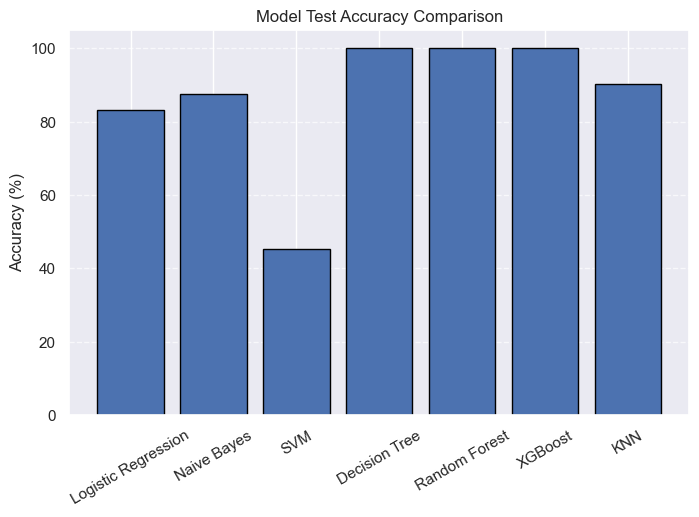

In [1]:
import os
os.chdir(r"C:\Users\KAUSHIK\CreditPathAI_Oct_Batch")
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

from imblearn.over_sampling import SMOTE

df = pd.read_csv("data/Loan_Default.csv")
print("Shape:", df.shape)
print(df.head())

TARGET = "Status"
print("\nTarget distribution before cleaning:")
print(df[TARGET].value_counts())

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET in cat_cols:
    cat_cols.remove(TARGET)

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after cleaning:")
print(df.isnull().sum())

le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("\nShape after encoding:", df.shape)

X = df.drop(columns=[TARGET])
y = df[TARGET]

X.columns = (
    X.columns
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("\nTrain/Test Split Done:")
print("Train:", X_train.shape, "| Test:", X_test.shape)

scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("\nBefore SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', max_iter=1000, probability=True, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []
trained_models = {}

for name, model in models.items():
    print("\n===============================")
    print(f"Training Model: {name}")
    print("===============================")

    
    start_train = time.time()
    model.fit(X_train_sm, y_train_sm)
    end_train = time.time()
    train_time = end_train - start_train

    trained_models[name] = model

    
    y_train_pred = model.predict(X_train_sm)
    train_accuracy = accuracy_score(y_train_sm, y_train_pred)

    tn, fp, fn, tp = confusion_matrix(y_train_sm, y_train_pred).ravel()
    train_sensitivity = tp / (tp + fn)
    train_specificity = tn / (tn + fp)
    train_f1 = f1_score(y_train_sm, y_train_pred)

    try:
        train_proba = model.predict_proba(X_train_sm)[:, 1]
        train_auc = roc_auc_score(y_train_sm, train_proba)
    except:
        train_auc = None

    # TEST PREDICTION
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    infer_time = end_pred - start_pred

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except:
        auc = None

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    test_specificity = tn / (tn + fp)

    
    results.append([
        name,

        # Train Metrics
        train_accuracy * 100,
        train_sensitivity * 100,
        train_specificity * 100,
        train_f1 * 100,
        train_auc * 100 if train_auc else None,

        
        acc * 100,
        rec * 100,
        test_specificity * 100,
        f1 * 100,
        auc * 100 if auc else None,

        # Time
        train_time,
        infer_time
    ])

    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

results_df = pd.DataFrame(results, columns=[
    "Model",
    "Train Accuracy", "Train Sensitivity", "Train Specificity",
    "Train F1", "Train AUC",
    "Test Accuracy", "Test Sensitivity", "Test Specificity",
    "Test F1", "Test AUC",
    "Training Time (sec)", "Prediction Time (sec)"
])

print("\n===== FINAL RESULTS =====\n")
print(results_df)

plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Test Accuracy"], edgecolor="black")
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
